In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Data.zip

drive.flush_and_unmount()

In [ ]:
df = pd.read_csv("Data/features_30_sec.csv")
df = df[['filename','label']]

In [ ]:
df = df[df['filename'] != "jazz.00054.wav"]
df = df.reset_index()
df.pop('index')

0        0
1        1
2        2
3        3
4        4
      ... 
994    995
995    996
996    997
997    998
998    999
Name: index, Length: 999, dtype: int64

In [ ]:
class_name = {}
n = 0
for i in set(df['label']):
    class_name[i] = n
    n+=1
num_classes = n

In [ ]:
df['label'] = df['label'].map(class_name)

In [ ]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [ ]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [ ]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [ ]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [ ]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}
    every_n_epoch = 5

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            losses[phase] += [epoch_loss]
            accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

### Need to define our model below

In [ ]:
# image shape is (221, 339, 1)

model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((3,3), (2,2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,3), (2,2)),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((5,6), (5,6)),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((6,6), (5,4)),
            nn.Flatten(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=1024, out_features=10))

In [ ]:
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# of trainable parameters: 1972938


In [ ]:
torch.cuda.empty_cache() 

In [ ]:
model = model.to(device)

In [ ]:
model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 2.2716 Acc: 0.1865
val Loss: 1.8279 Acc: 0.3300

Epoch 1/24
----------
train Loss: 1.7030 Acc: 0.3855
val Loss: 1.3702 Acc: 0.4800

Epoch 2/24
----------
train Loss: 1.4965 Acc: 0.4581
val Loss: 1.2994 Acc: 0.5700

Epoch 3/24
----------
train Loss: 1.4197 Acc: 0.4931
val Loss: 1.2121 Acc: 0.6400

Epoch 4/24
----------
train Loss: 1.3149 Acc: 0.5269
val Loss: 1.2439 Acc: 0.5700

Epoch 5/24
----------
train Loss: 1.2152 Acc: 0.5620
val Loss: 1.1325 Acc: 0.6100

Epoch 6/24
----------
train Loss: 1.0490 Acc: 0.6571
val Loss: 1.4590 Acc: 0.5200

Epoch 7/24
----------
train Loss: 0.8980 Acc: 0.7134
val Loss: 0.8519 Acc: 0.7500

Epoch 8/24
----------
train Loss: 0.8270 Acc: 0.7259
val Loss: 0.8366 Acc: 0.7400

Epoch 9/24
----------
train Loss: 0.7771 Acc: 0.7622
val Loss: 0.8266 Acc: 0.7800

Epoch 10/24
----------
train Loss: 0.7424 Acc: 0.7710
val Loss: 0.8080 Acc: 0.7800

Epoch 11/24
----------
train Loss: 0.7273 Acc: 0.7835
val Loss: 0.7919 Acc: 0.7900

Ep

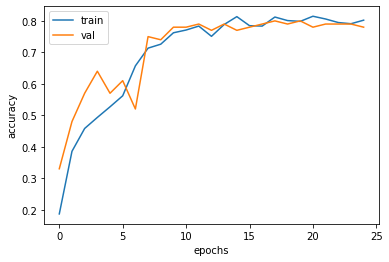

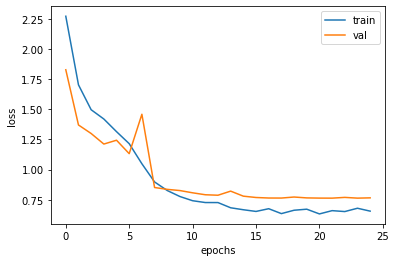

In [ ]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)

In [ ]:
torch.save(model.state_dict(),"weights.pth")

In [ ]:
def test_model(model):

    model.eval()   # Set model to evaluate mode

    # t_output = []
    t_pred = []
    y_test = []

    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)
        
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        
        # t_output.append(outputs)
        t_pred.append(preds)
           
    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
   
    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test, zero_division=0))

In [ ]:
torch.cuda.empty_cache() 


Confusion Matrix
[[9 0 0 0 0 0 2 0 0 1]
 [0 8 0 0 1 0 0 0 0 0]
 [0 0 7 1 0 0 0 0 0 2]
 [0 0 0 6 0 1 0 0 0 1]
 [0 0 2 0 7 0 0 0 0 0]
 [0 1 0 1 0 5 0 0 1 0]
 [0 0 0 1 0 0 8 0 0 1]
 [0 0 0 0 0 0 0 9 0 1]
 [0 0 0 1 0 4 0 1 9 0]
 [1 1 1 0 2 0 0 0 0 4]]


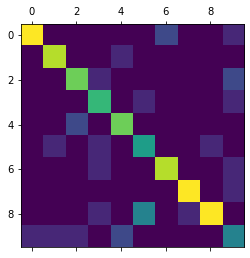


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82        12
           1       0.80      0.89      0.84         9
           2       0.70      0.70      0.70        10
           3       0.60      0.75      0.67         8
           4       0.70      0.78      0.74         9
           5       0.50      0.62      0.56         8
           6       0.80      0.80      0.80        10
           7       0.90      0.90      0.90        10
           8       0.90      0.60      0.72        15
           9       0.40      0.44      0.42         9

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.74      0.72      0.72       100



In [ ]:
test_model(model)

In [ ]:
print(torch.__version__)

1.10.0+cu111


### Recommendation

In [ ]:
list(model.modules())[1:]

[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 MaxPool2d(kernel_size=(2, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 MaxPool2d(kernel_size=(5, 6), stride=(5, 6), padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(),
 MaxPool2d(kernel_size=(6, 6), stride=(5, 4), padding=0, dilation=1, ceil_mode=False),
 Flatten(sta

In [ ]:
# strips off last linear layer and dropout layer
my_model = nn.Sequential(*(list(model.modules())[1:])[:-2]) 

In [ ]:
class SongEncoderDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': img_name.split('/')[-1].split(".")[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

transformed_dataset = SongEncoderDataset(csv_file=df,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
whole_dataloader = DataLoader(transformed_dataset, batch_size=16,
                        shuffle=False, num_workers=0)

def song_encoder(model):
                
    model.eval()   # Set model to evaluate mode

    song_name = []
    song_encoded = []

    # Iterate over data.
    for inputs, labels in whole_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs.float())
        temp = outputs.cpu().detach().numpy()
        song_name += list(labels)
        for i in temp:
          song_encoded.append(i/np.linalg.norm(i))

    return song_name, song_encoded

song_name, song_encoded = song_encoder(my_model)
song_encoded = np.array(song_encoded)
import pickle
with open('song_embed.pkl', 'wb') as f:
   pickle.dump(song_encoded, f)
with open('song_name.pkl', 'wb') as f:
   pickle.dump(song_name, f)

In [ ]:
import pickle
with open('song_embed.pkl', 'rb') as f:
   song_vec = pickle.load(f)
with open('song_name.pkl', 'rb') as f:
   song_name = pickle.load(f)

In [ ]:
def songRecomendation(song_name, song_embed, new_song, k=5):
  ls = np.argpartition(np.dot(song_embed,new_song/np.linalg.norm(new_song)), -k)[-k:]
  # print(np.dot(song_embed,new_song/np.linalg.norm(new_song)))
  return [song_name[i] for i in ls]

In [ ]:
query = 'pop00000'
q = song_name.index('pop00000')
songRecomendation(song_name, song_vec, song_vec[q], k=3)

['pop00095', 'pop00076', 'pop00000']

### TSNE to visualize embeddings

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE()
embed_tsne = tsne.fit_transform(song_vec)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tmp_idx = []
tmp = None
for i in range(10):
  start = i*100 
  end = start+10
  tmp_idx += list(range(start,end))
  if tmp is None:
    tmp = embed_tsne[start:end]
  else: tmp += embed_tsne[start:end]

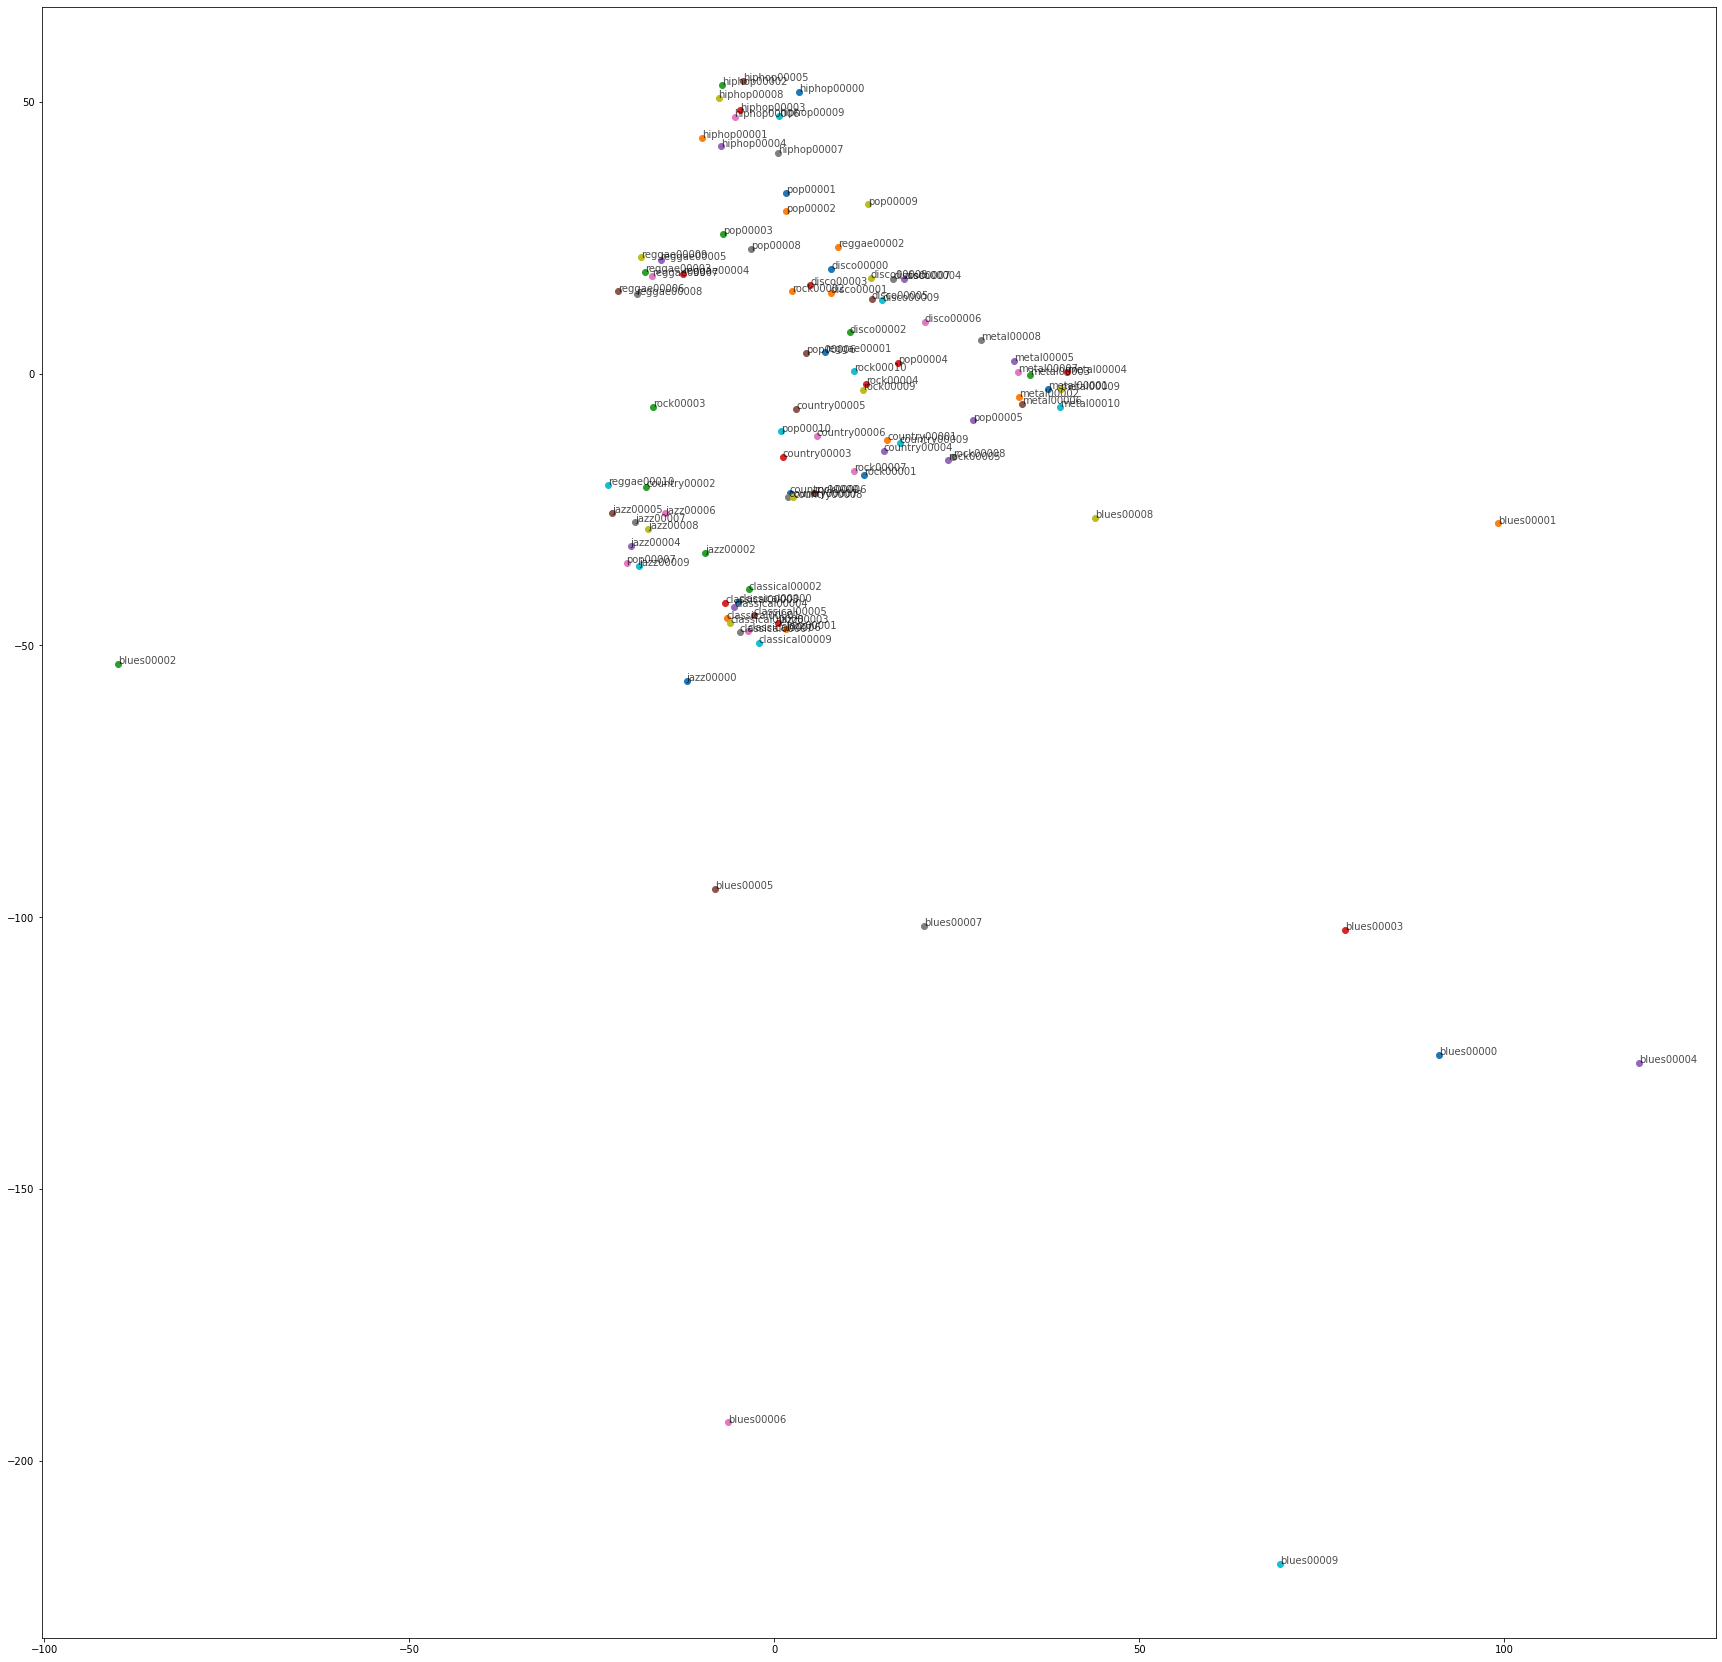

In [ ]:
fig, ax = plt.subplots(figsize=(30, 30))

for idx in tmp_idx:
  plt.scatter(*embed_tsne[idx, :])
  plt.annotate(song_name[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)